In [14]:
import numpy as np
import scipy
import librosa, librosa.display
print(librosa.__version__)
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavf
#render plot option - matplotlib inline or matplotlib notebook or matplotlib nbagg
%matplotlib widget
#select a different color-scheme for the plots
import matplotlib.style as ms
ms.use("seaborn-v0_8")  
import IPython.display as Ipd

0.10.1


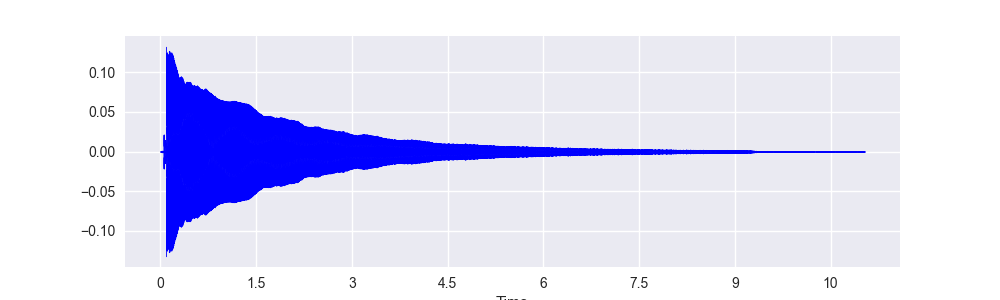

In [15]:
note_name = 'E8'
note_type = 'circular'
note_index = 4
sr = 44100 # sampling rate

sample_name = f'{note_name}-{note_type}'
filepath = f'data-processed/{sample_name}/{sample_name}-sound-{note_index}.wav'
static_signal, sr = librosa.load(filepath, sr=sr, mono=False)

sensor_name = f'{sample_name}-sensors-left-{note_index}.npy'
sensor_path = f'data-processed/{sample_name}/{sensor_name}'
sensor_data = np.load(sensor_path)

plt.figure(figsize=(10, 3))
librosa.display.waveshow(y=static_signal, sr=sr, color="blue")

Ipd.Audio(static_signal, rate=sr) # play audio

Text(0.5, 1.0, 'gyroscope-z')

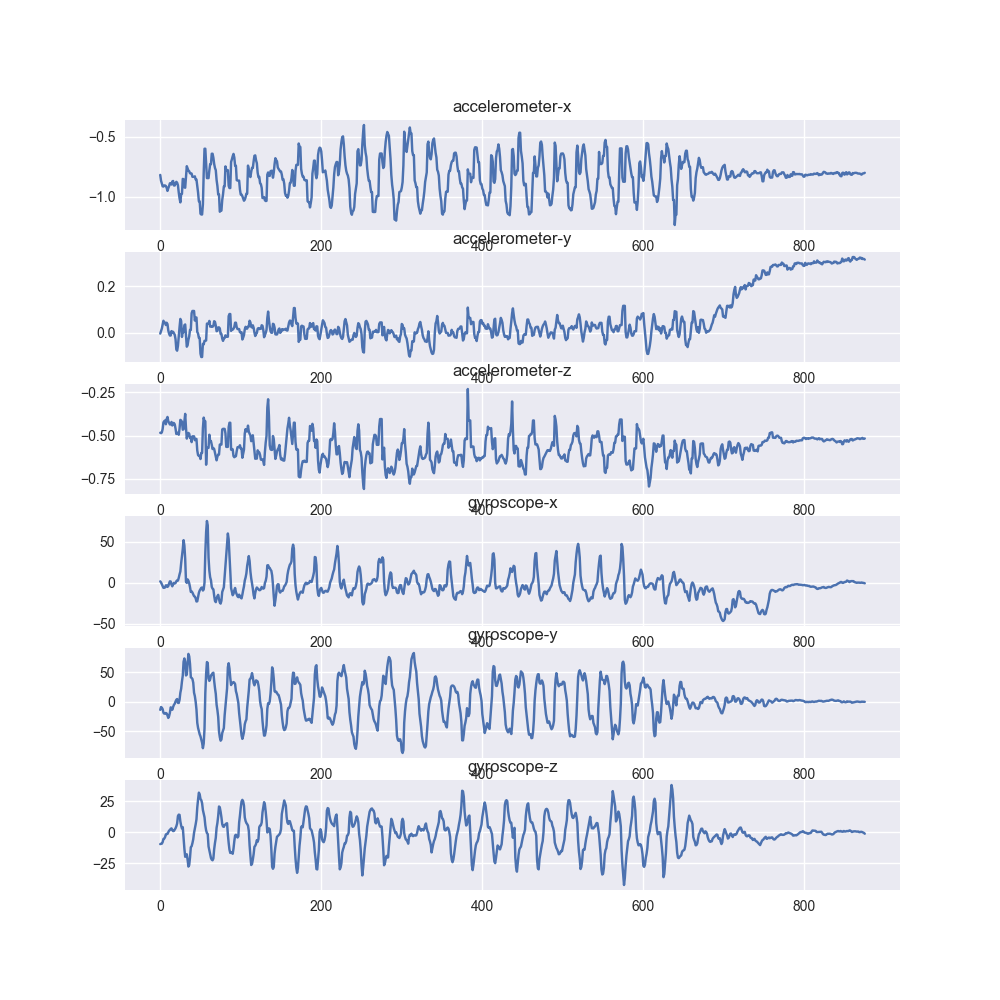

In [16]:
fig, ax = plt.subplots(6, figsize=(10,10))
ax[0].plot(sensor_data[0])
ax[0].set_title('accelerometer-x')
ax[1].plot(sensor_data[1])
ax[1].set_title('accelerometer-y')
ax[2].plot(sensor_data[2])
ax[2].set_title('accelerometer-z')
ax[3].plot(sensor_data[3])
ax[3].set_title('gyroscope-x')
ax[4].plot(sensor_data[4])
ax[4].set_title('gyroscope-y')
ax[5].plot(sensor_data[5])
ax[5].set_title('gyroscope-z')

In [17]:
from scipy.signal import butter, lfilter
from scipy.signal import freqz

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Sample rate and desired cutoff frequencies (in Hz).
fs = sr
lowcut = 50 # filtering out background noise
highcut = 20000

/var/folders/60/xw_4m7ds65q08s4l62v0_4pr0000gp/T/ipykernel_57497/3090016425.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10,3))


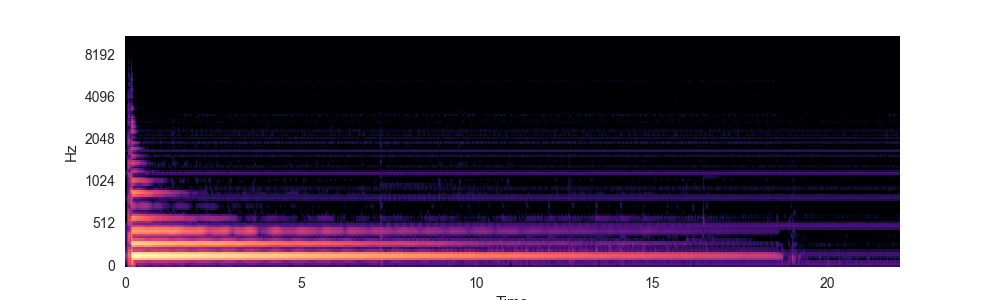

In [18]:
filtered_static = butter_bandpass_filter(static_signal, lowcut, highcut, sr, order=6) # filtered signal
D_static = librosa.amplitude_to_db(np.abs(librosa.stft(filtered_static)), ref=np.max)
S = librosa.feature.melspectrogram(y=filtered_static, sr=sr, n_mels=128,fmax=8000)
S_static = librosa.power_to_db(S, ref=np.max)

fig, ax = plt.subplots(figsize=(10,3))
img = librosa.display.specshow(S_static, x_axis='time', y_axis='mel', ax=ax, hop_length=512)

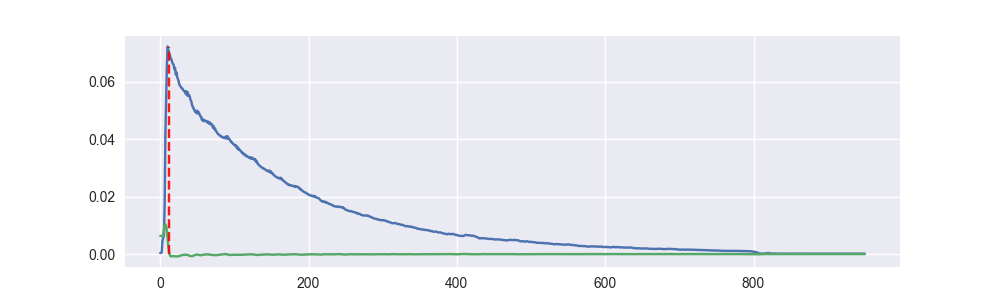

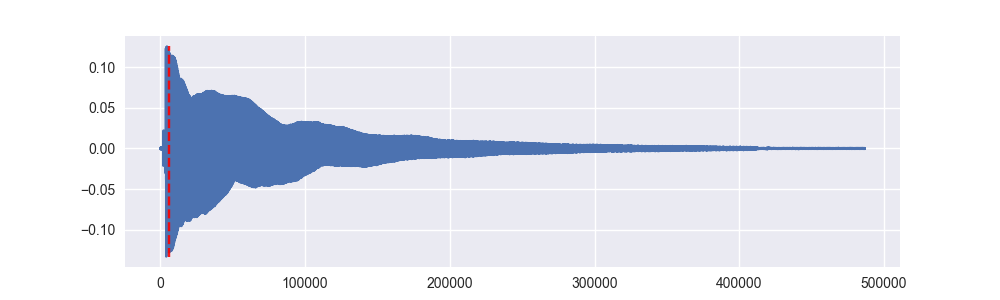

In [19]:
rms_static = librosa.feature.rms(y=filtered_static)
rms_static_delta = librosa.feature.delta(rms_static)
zero_crossings_static = np.where(np.diff(np.sign(rms_static_delta)))[1]

min_idx = 0
max_idx = 10000
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(rms_static[0, min_idx:max_idx])
ax.plot(rms_static_delta[0, min_idx:max_idx])
ax.vlines(zero_crossings_static[0], rms_static.min(), rms_static.max(), 
               color='r', alpha=0.9, linestyle='--', label='Onsets')

cut_sample_static = librosa.frames_to_samples(zero_crossings_static)[0]
static_signal_noHead = static_signal[cut_sample_static:]
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(static_signal)
ax.vlines(cut_sample_static, static_signal.min(), static_signal.max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')

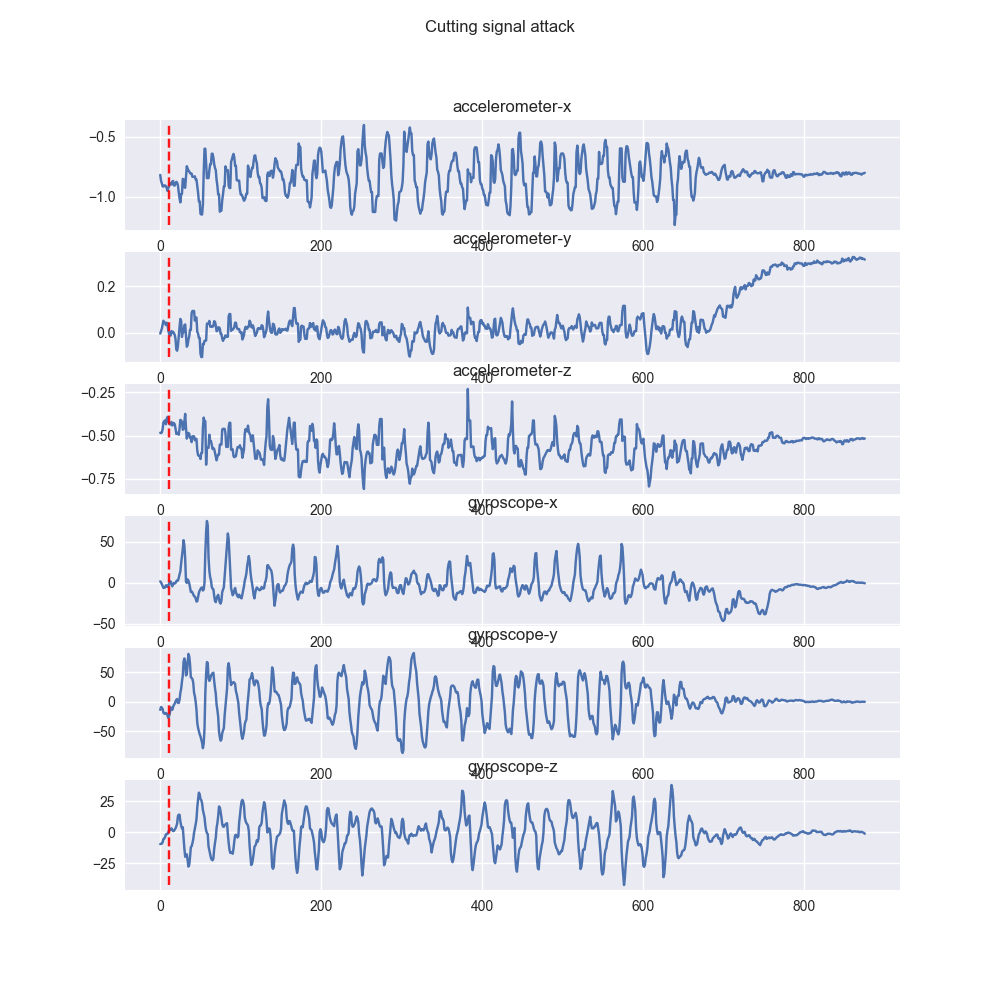

In [20]:
signal_duration = static_signal.shape[0] / sr
# interval at which a new sensor data is received
sensor_interval = signal_duration / sensor_data.shape[1]
sound2sensor = sensor_data.shape[1] / static_signal.shape[0]
sensor_peaks = librosa.frames_to_samples(zero_crossings_static[0]) * sound2sensor

fig, ax = plt.subplots(6, figsize=(10,10))
ax[0].plot(sensor_data[0])
ax[0].set_title('accelerometer-x')
ax[0].vlines(sensor_peaks, sensor_data[0].min(), sensor_data[0].max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')
ax[1].plot(sensor_data[1])
ax[1].set_title('accelerometer-y')
ax[1].vlines(sensor_peaks, sensor_data[1].min(), sensor_data[1].max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')

ax[2].plot(sensor_data[2])
ax[2].set_title('accelerometer-z')
ax[2].vlines(sensor_peaks, sensor_data[2].min(), sensor_data[2].max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')

ax[3].plot(sensor_data[3])
ax[3].set_title('gyroscope-x')
ax[3].vlines(sensor_peaks, sensor_data[3].min(), sensor_data[3].max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')

ax[4].plot(sensor_data[4])
ax[4].set_title('gyroscope-y')
ax[4].vlines(sensor_peaks, sensor_data[4].min(), sensor_data[4].max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')

ax[5].plot(sensor_data[5])
ax[5].set_title('gyroscope-z')
ax[5].vlines(sensor_peaks, sensor_data[5].min(), sensor_data[5].max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')
fig.suptitle('Cutting signal attack')

# cut sensor data
sensor_data_noHead = sensor_data[:,int(sensor_peaks):]

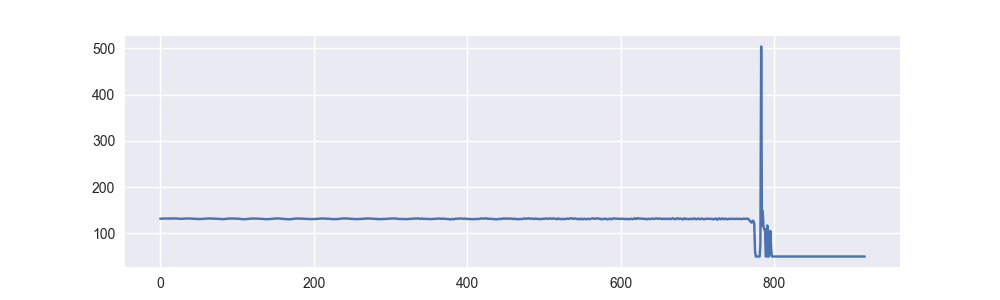

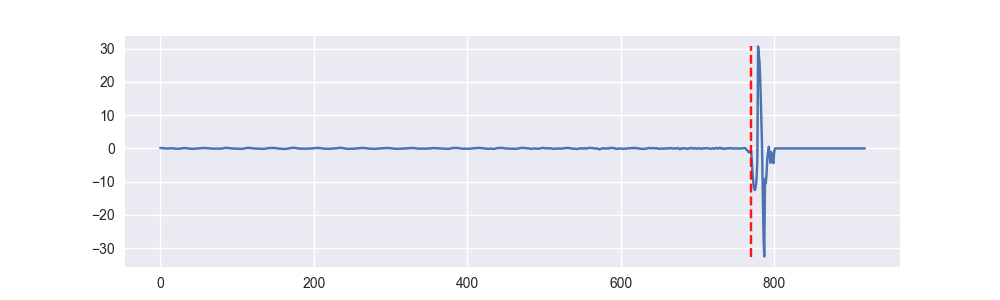

In [21]:
cent_static = librosa.yin(y=static_signal_noHead, sr=sr, fmin=50, fmax=880)
min_idx = 20
max_idx = 10000
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(cent_static[min_idx:max_idx])

k = 5 # average of the k frequencies with max amplitudes
mean_f0_static = np.mean(cent_static[np.argpartition(rms_static[0], len(rms_static[0]) - k)[-k:]])

cut_thresh = 3
cent_static_delta = librosa.feature.delta(cent_static)
try:
    cut_idx_static = np.where(np.abs(cent_static_delta[min_idx:max_idx]) > cut_thresh)[0][0] -1
except:
    cut_idx_static = None

min_idx = 20
max_idx = 1000
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(cent_static_delta[min_idx:max_idx])
if cut_idx_static:
    ax.vlines(cut_idx_static, cent_static_delta.min(), cent_static_delta.max(), 
               color='r', alpha=0.9, linestyle='--', label='Onsets')

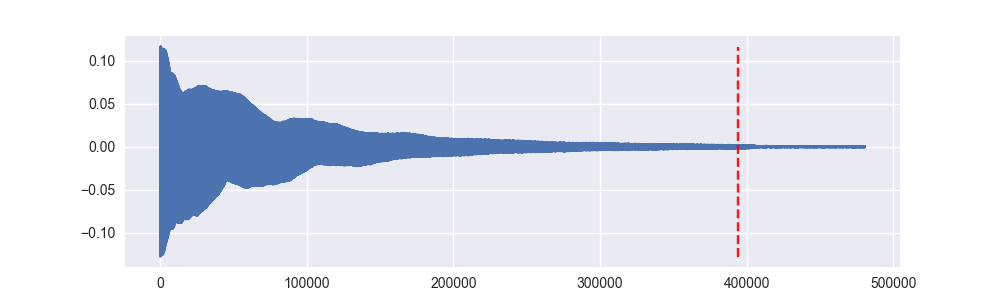

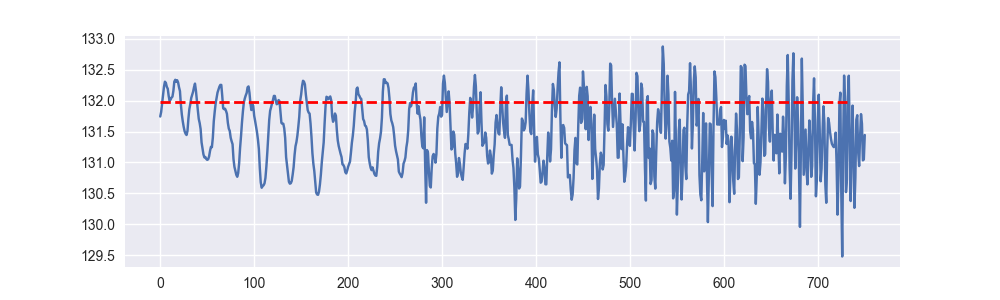

In [22]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(static_signal_noHead)
if cut_idx_static:
    cut_sample_static = librosa.frames_to_samples(cut_idx_static)
    static_signal_noTail = static_signal_noHead[:cut_sample_static]
    ax.vlines(cut_sample_static, static_signal_noHead.min(), static_signal_noHead.max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')

min_idx = 20
if cut_idx_static:
    cent_static = librosa.yin(y=static_signal_noTail, sr=sr, fmin=50, fmax=880)[min_idx:]
else:
    cent_static = cent_static[min_idx:]

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(cent_static)
ax.hlines(y=mean_f0_static, xmin=0, xmax=cent_static[min_idx:].shape[0], 
             linewidth=2, color='r', linestyle='--')

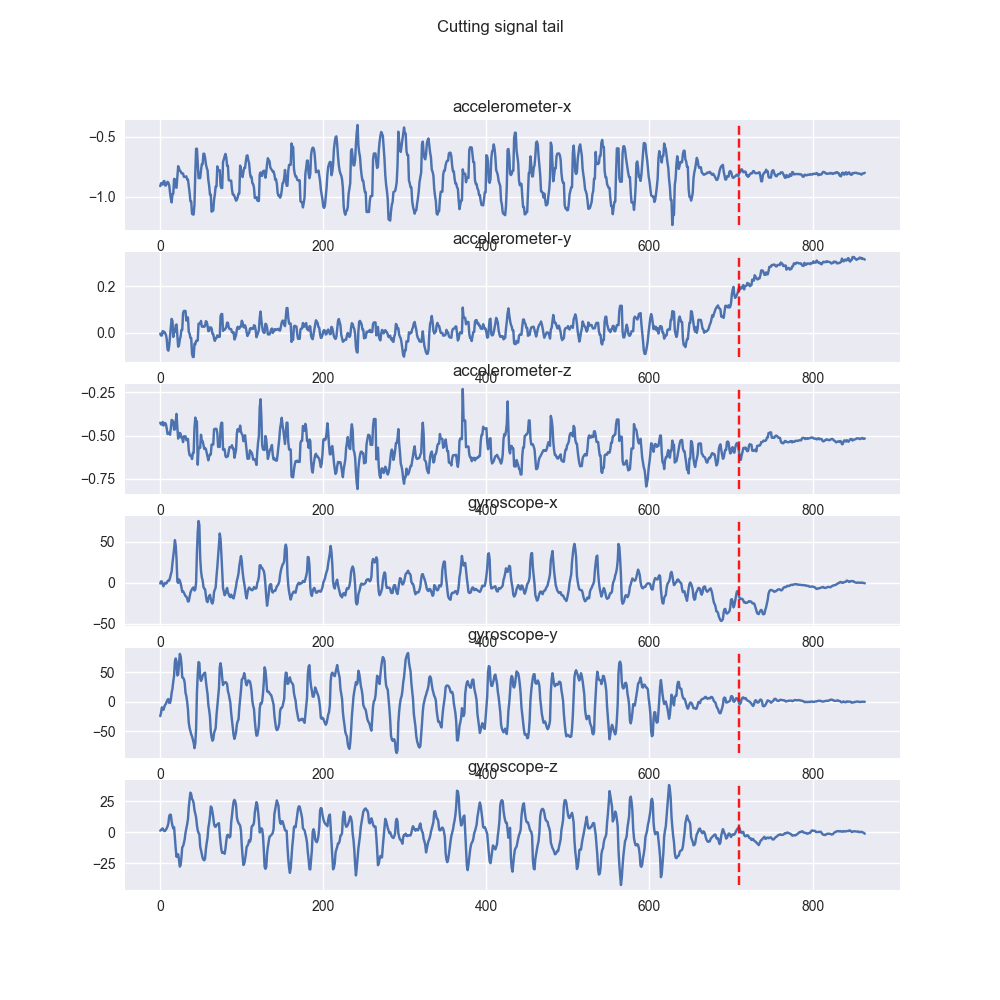

In [23]:
signal_duration = static_signal_noHead.shape[0] / sr
# interval at which a new sensor data is received
sensor_interval = signal_duration / sensor_data_noHead.shape[1]
sound2sensor = sensor_data_noHead.shape[1] / static_signal_noHead.shape[0]
sensor_peaks = librosa.frames_to_samples(cut_idx_static) * sound2sensor

fig, ax = plt.subplots(6, figsize=(10,10))
ax[0].plot(sensor_data_noHead[0])
ax[0].set_title('accelerometer-x')
ax[0].vlines(sensor_peaks, sensor_data_noHead[0].min(), sensor_data_noHead[0].max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')
ax[1].plot(sensor_data_noHead[1])
ax[1].set_title('accelerometer-y')
ax[1].vlines(sensor_peaks, sensor_data_noHead[1].min(), sensor_data_noHead[1].max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')

ax[2].plot(sensor_data_noHead[2])
ax[2].set_title('accelerometer-z')
ax[2].vlines(sensor_peaks, sensor_data_noHead[2].min(), sensor_data_noHead[2].max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')

ax[3].plot(sensor_data_noHead[3])
ax[3].set_title('gyroscope-x')
ax[3].vlines(sensor_peaks, sensor_data_noHead[3].min(), sensor_data_noHead[3].max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')

ax[4].plot(sensor_data_noHead[4])
ax[4].set_title('gyroscope-y')
ax[4].vlines(sensor_peaks, sensor_data_noHead[4].min(), sensor_data_noHead[4].max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')

ax[5].plot(sensor_data_noHead[5])
ax[5].set_title('gyroscope-z')
ax[5].vlines(sensor_peaks, sensor_data_noHead[5].min(), sensor_data_noHead[5].max(), 
           color='r', alpha=0.9, linestyle='--', label='Onsets')

fig.suptitle('Cutting signal tail')
# cut sensor data
sensor_data_noTail = sensor_data_noHead[:int(sensor_peaks)]

Text(0.5, 1.0, 'gyroscope-z')

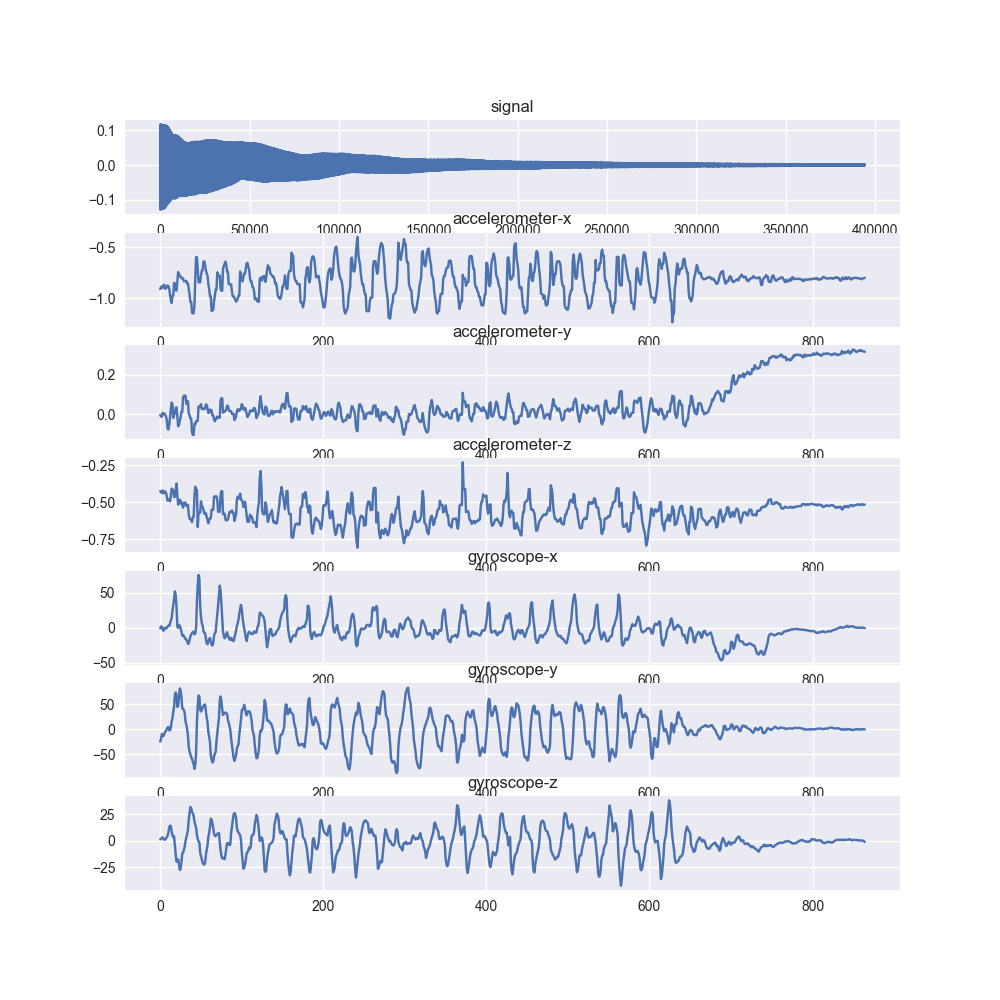

In [24]:
fig, ax = plt.subplots(7, figsize=(10,10))
ax[0].plot(static_signal_noTail)
ax[0].set_title('signal')
ax[1].plot(sensor_data_noTail[0])
ax[1].set_title('accelerometer-x')
ax[2].plot(sensor_data_noTail[1])
ax[2].set_title('accelerometer-y')
ax[3].plot(sensor_data_noTail[2])
ax[3].set_title('accelerometer-z')
ax[4].plot(sensor_data_noTail[3])
ax[4].set_title('gyroscope-x')
ax[5].plot(sensor_data_noTail[4])
ax[5].set_title('gyroscope-y')
ax[6].plot(sensor_data_noTail[5])
ax[6].set_title('gyroscope-z')

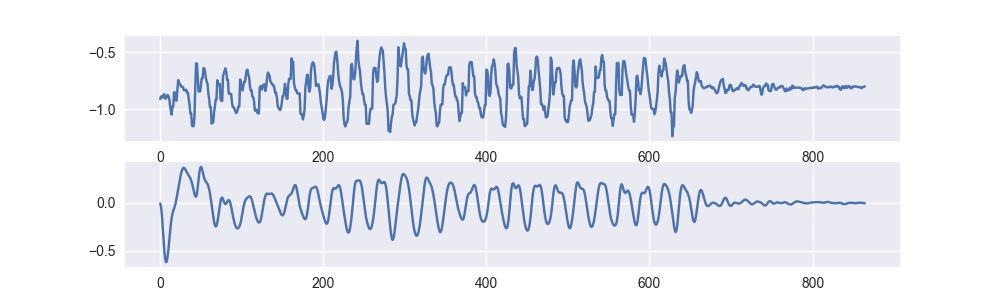

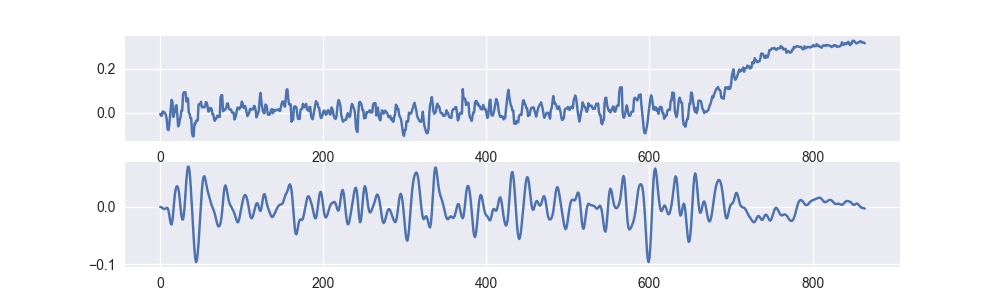

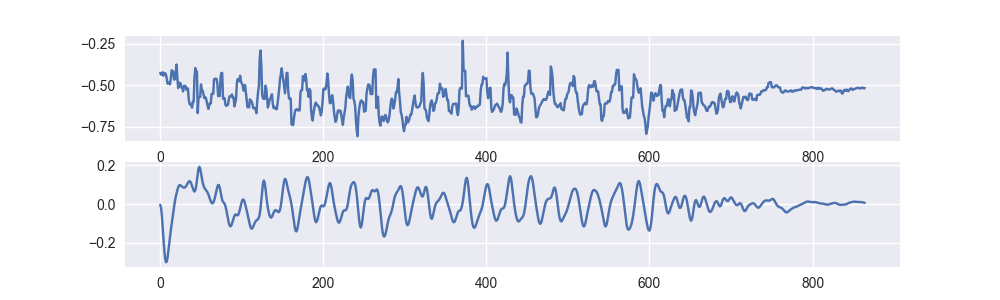

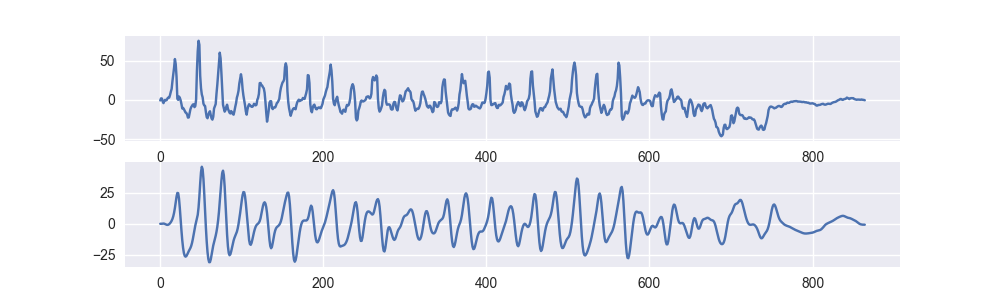

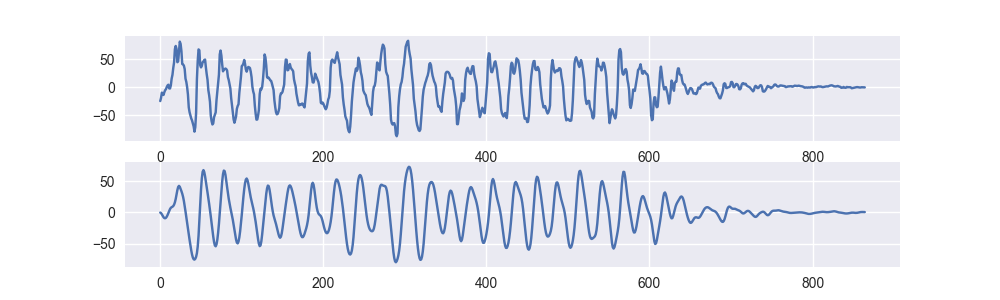

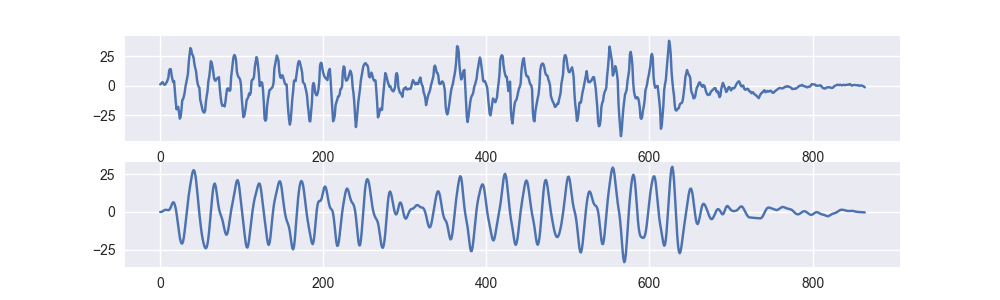

In [25]:
lowcut, highcut = 1e-4, 0.001
sr_sensors = sensor_interval

filtered_sensors = []
filtered_sensor0 = butter_bandpass_filter(sensor_data_noTail[0], lowcut, highcut, 
                                          sr_sensors, order=3) # filtered signal
filtered_sensor1 = butter_bandpass_filter(sensor_data_noTail[1], lowcut, highcut, 
                                          sr_sensors, order=3) # filtered signal
filtered_sensor2 = butter_bandpass_filter(sensor_data_noTail[2], lowcut, highcut, 
                                          sr_sensors, order=3) # filtered signal
filtered_sensor3 = butter_bandpass_filter(sensor_data_noTail[3], lowcut, highcut, 
                                          sr_sensors, order=3) # filtered signal
filtered_sensor4 = butter_bandpass_filter(sensor_data_noTail[4], lowcut, highcut, 
                                          sr_sensors, order=3) # filtered signal
filtered_sensor5 = butter_bandpass_filter(sensor_data_noTail[5], lowcut, highcut, 
                                          sr_sensors, order=3) # filtered signal

filtered_sensors.append(filtered_sensor0)
filtered_sensors.append(filtered_sensor1)
filtered_sensors.append(filtered_sensor2)
filtered_sensors.append(filtered_sensor3)
filtered_sensors.append(filtered_sensor4)
filtered_sensors.append(filtered_sensor5)

filtered_sensors = np.array(filtered_sensors)

fig, ax = plt.subplots(2, figsize=(10,3))
ax[0].plot(sensor_data_noTail[0])
ax[1].plot(filtered_sensor0)

fig, ax = plt.subplots(2, figsize=(10,3))
ax[0].plot(sensor_data_noTail[1])
ax[1].plot(filtered_sensor1)

fig, ax = plt.subplots(2, figsize=(10,3))
ax[0].plot(sensor_data_noTail[2])
ax[1].plot(filtered_sensor2)

fig, ax = plt.subplots(2, figsize=(10,3))
ax[0].plot(sensor_data_noTail[3])
ax[1].plot(filtered_sensor3)

fig, ax = plt.subplots(2, figsize=(10,3))
ax[0].plot(sensor_data_noTail[4])
ax[1].plot(filtered_sensor4)

fig, ax = plt.subplots(2, figsize=(10,3))
ax[0].plot(sensor_data_noTail[5])
ax[1].plot(filtered_sensor5)

In [26]:
# save audio and sensors
sample_name = f'{note_name}-{note_type}'
filepath = f'data-processed/{sample_name}/{sample_name}-sound-{note_index}_pre-processed.wav'
wavf.write(filepath, sr, static_signal_noTail)

sensor_name = f'{sample_name}-sensors-left-{note_index}_pre-processed.npy'
sensor_path = f'data-processed/{sample_name}/{sensor_name}'
np.save(sensor_path, sensor_data_noTail)

sensor_name = f'{sample_name}-sensors-left-{note_index}_pre-processed_filtered.npy'
sensor_path = f'data-processed/{sample_name}/{sensor_name}'
np.save(sensor_path, filtered_sensors)

min_idx = 20
cent_static = librosa.yin(y=static_signal_noTail, sr=sr, fmin=50, fmax=880)[min_idx:]-mean_f0_static
fig, ax = plt.subplots()
ax.plot(cent_static)
ax.hlines(y=0, xmin=0, xmax=cent_static[min_idx:].shape[0], 
             linewidth=2, color='r', linestyle='--')
ax.set_ylabel('$f_0$')

(-100.0, 100.0)

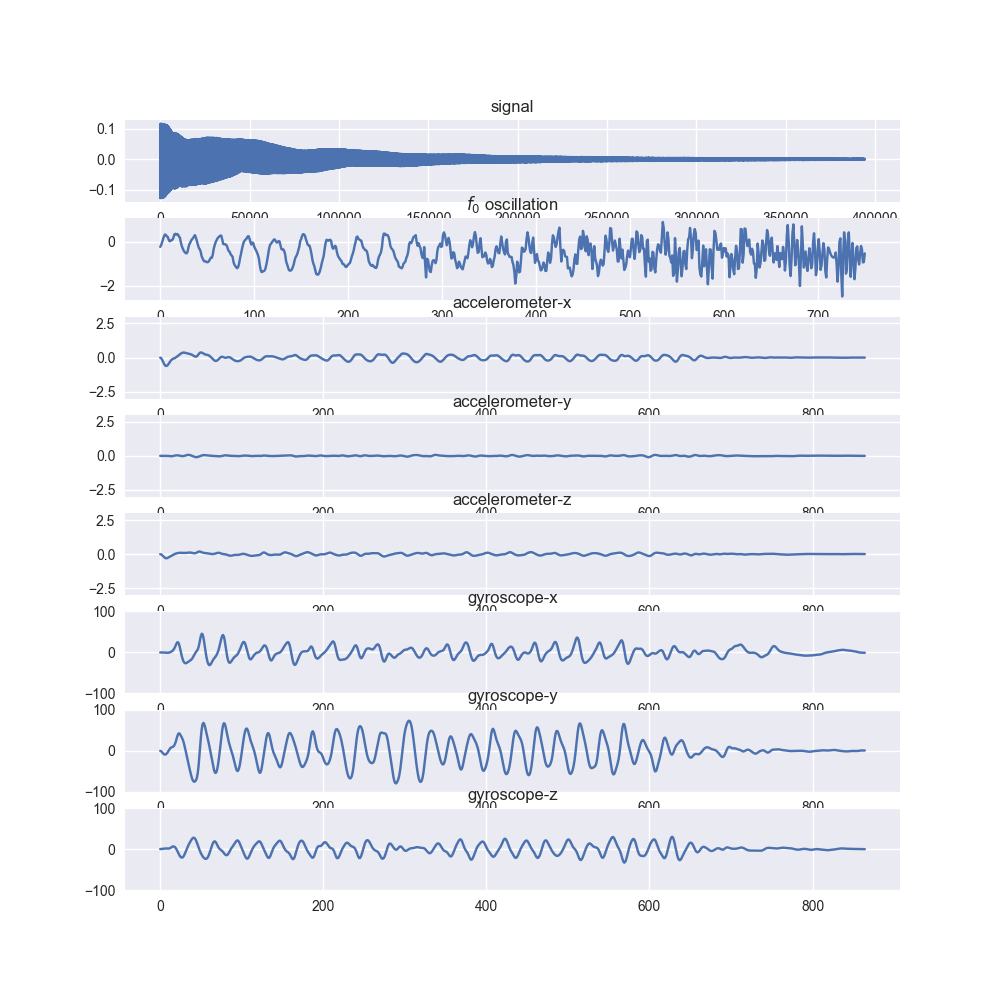

In [40]:
fig, ax = plt.subplots(8, figsize=(10,10))
ax[0].plot(static_signal_noTail)
ax[0].set_title('signal')
ax[1].plot(cent_static)
ax[1].set_title('$f_0$ oscillation')
ax[2].plot(filtered_sensor0)
ax[2].set_title('accelerometer-x')
ax[3].plot(filtered_sensor1)
ax[3].set_title('accelerometer-y')
ax[4].plot(filtered_sensor2)
ax[4].set_title('accelerometer-z')
ax[5].plot(filtered_sensor3)
ax[5].set_title('gyroscope-x')
ax[6].plot(filtered_sensor4)
ax[6].set_title('gyroscope-y')
ax[7].plot(filtered_sensor5)
ax[7].set_title('gyroscope-z')
ax[2].set_ylim([-3, 3])
ax[3].set_ylim([-3, 3])
ax[4].set_ylim([-3, 3])
ax[5].set_ylim([-100, 100])
ax[6].set_ylim([-100, 100])
ax[7].set_ylim([-100, 100])

In [38]:
cent_static.shape

(751,)

In [39]:
filtered_sensor5.shape

(865,)